## A/B-тестирование на конверсию и средний чек двух программ туроператора

### Задача: 
Проанализировать эффективность 2 вариантов посадочной страницы турагентства по двум критериям — конверсии покупки и ежедневному среднему чеку.

### План:
1. Анализ струтктуры данных и предобработка
2. Расчет ключевых метрик для АВ-тестов
3. Предварительные результаты
4. Проверка стабилизации метрик 
5. Статистический анализ результатов A/B-тестирования
6. Вывод: какой вариант посадочной страницы более предпочтителен по метрикам конверсии и ежедневного среднего чека

Компания предлагает следующие варианты туров:

Таиланд — 100 000 рублей;\
Турция — 60 000 рублей;\
Мальдивы — 200 000 рублей;\
Санкт-Петербург — 10 000 рублей;\
Камчатка — 150 000 рублей.

Также у нас есть данные к какой тестовой группе относился клиент, и совершил он покупку или нет

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import shapiro

Импортируем данные

In [116]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Наша таблица представлена следующими полями:

user_id — идентификатор пользователя, зашедшего на сайт;\
data — дата посещения сайта;\
group — группа теста (контрольная — А или тестовая — B);\
purchase — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);\
price — цена купленного тура (если покупка не состоялась, цена равна 0).

	
## 1. Анализ струтктуры данных и предобработка

Для этого проведем:
- исследование структуру данных;
- преобразование к необходимым типам данных.
- Убедимся в одинаковой длительности проведения A/B-тестирования в каждой из групп. Если длительность разная, унифицируем данные, удалив лишние данные для соответствующей группы.
- Проверим данные на наличие пропусков и избавимся от них, если нужно.
- Проверим, есть ли пользователи, которые в процессе A/B-теста попали в обе группы. Если да, исключим


In [117]:
# проверим на пропуски и посмотрим структуру
data.info()

# проверим на полные дубликаты
mask = data.duplicated() # Создадим маску дубликатов с помощью метода duplicated() в которой True помечены дубликаты, а False — уникальные записи
duplicates = data[mask]
print(f'Число найденных полных дубликатов: {duplicates.shape[0]}')
# удалим дубликаты
data = data.drop_duplicates()

# проверим на дубликаты по id
mask = data.duplicated(subset='user_id') # Создадим маску дубликатов с помощью метода duplicated() в которой True помечены дубликаты, а False — уникальные записи
duplicates = data[mask]
print(f'Число найденных дубликатов по id: {duplicates.shape[0]}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB
Число найденных полных дубликатов: 74
Число найденных дубликатов по id: 3820


Пропусков нет

Найдено 74 полных дубликата, т.е. по сути строк, которые просто записали более одного раза. В этом случае просто удаляем строки-дубликаты

Найдено также 3820 пользователя, которые прошли тестирование более одного раза. Прошли они в рамках одной группы или разных - не так важно, потому что они уже внесут погрешность в анализ. Поэтому исключим всех пользователей, прошедших интервью более одного раза, из обеих групп

In [118]:
# создадим список с повторяющимися id, чтобы исключить их в обоих экзеплярах
duplicates_list = list(duplicates['user_id'])
# 
data = data[~data['user_id'].isin(duplicates_list)]

Теперь удалены 7640 наблюдений, соответствующие людям, учавствующий в тестировании более одного раза.

In [119]:
# переведем дату в формат datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# проверим, что тестирование в обеих группах проводилось в одно и то же время, и сразу сделаем группировку по дням
daily_data = data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'users_count', 'purchase':'purchase_count', 'price':'sum_revenue'})
daily_data.head(8)


,date,group,users_count,purchase_count,sum_revenue
0,2021-01-02,A,2813,354,29170000
1,2021-01-02,B,2818,336,29050000
2,2021-01-03,A,6495,738,61420000
3,2021-01-03,B,6531,745,65030000
4,2021-01-04,A,6483,787,63050000
5,2021-01-04,B,6450,753,67050000
6,2021-01-05,A,6332,780,63460000
7,2021-01-05,B,6420,734,62150000


Видим, что обе группы тестировались в одни и те же дни и количество в каждом дне соизмеримое между группами

## 2. Расчет ключевых метрик для АВ-тестов

- Рассчитайем вспомогательные показатели для контрольной и тестовой групп:

    - количество посещений сайта;
    - суммарное количество совершённых покупок;
    - сумма всех покупок.

Сделаем промежуточные выводы по построенной таблице: сопоставимо ли количество посещений обоих вариантов посадочной страницы и можно ли говорить о сбалансированности выборок

- В каждой из групп рассчитаем ключевые показатели:

    - конверсия;
    - средний чек.


In [120]:
# посчитаем вспомогательные показатели для контрольной и тестовой групп
add_data = daily_data.groupby('group')[['users_count', 'purchase_count', 'sum_revenue']].sum()
add_data

,users_count,purchase_count,sum_revenue
group,,,
A,143332,17220,1396120000
B,143432,17025,1510100000


Можно заметить, что все показатели в обеих выборках сопоставимы, что говорит о хорошо сбалансированных данных. Интересно, что при примерно равном количестве посещений в выборке A - больше покупок, а в выборке B - выше суммарный чек, т.е. покупались более дорогие туры

In [ ]:
# Посчитаем конверсию и средний чек
daily_data['conversion(%)'] = round(daily_data['purchase_count']/daily_data['users_count']*100, 2)
daily_data['av_bill(RUB)'] = round(daily_data['sum_revenue']/daily_data['purchase_count'], 2)

## 3. Предварительные результаты

Сделаем первичные выводы о результатах A/B-тестирования на основе показателей конверсии и среднего чека в каждой из групп:

- По какому(-им) показателю(-ям), на первый взгляд, вариант А эффективнее варианта B и наоборот
- Сравним варианты A/B по покупательской способности каждого из туров. 
- По каким турам покупательская способность участников группы А выше, чем покупательская способность участников группы B, и наоборот

In [121]:
# группируем для выводов
conversion_piv = daily_data.groupby('group')[['conversion(%)', 'av_bill(RUB)']].agg(
    ['mean', 'median']
).round(2)
display(conversion_piv)

conversion(%)        av_bill(RUB)          
               mean median         mean    median
group                                            
A             12.02  12.02     80982.59  81462.80
B             11.87  11.84     88620.99  87881.04

Можно сделать предварительный вывод, что конверсия в первой группе выше, но средний чек - во второй. В целом вывод повторяет заключение предыдущего блока.

Text(0.5, 0, 'Country')

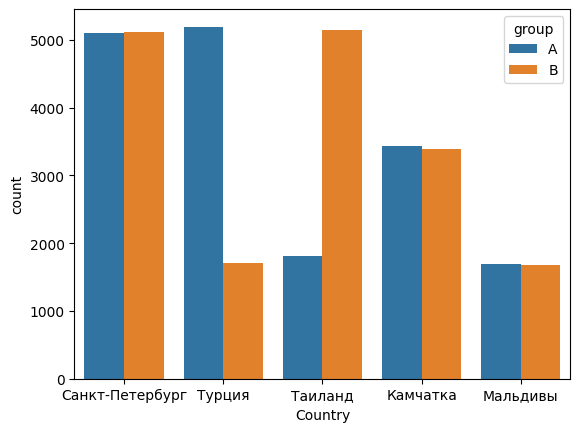

In [122]:
# делим на группы по городам и визуализируем данные
ax = sns.countplot(data=data[-(data.price == 0)], x='price', hue='group') # искоючим столбец с нулями, иначе он не дает нормально посмотреть купленные туры
# переименуем в соответствии с названиями
ax.set_xticklabels(['Санкт-Петербург', 'Турция', 'Таиланд', 'Камчатка', 'Мальдивы'])
ax.set_xlabel('Country')

Туры идут в порядке возрастания цены и можно заметить, что в группе A больше покупали туры в Турцию, которая дешевле, чем Тайланд, которому отдавали предпочтение клиенты второй группы. Значит в группе B смогли продать более дорогие туры.

## 4. Проверка стабилизации метрик 

- Сгруппируем данные по дате и группе тестирования и постройте таблицу с ежедневными данными результатов проведения A/B-тестирования. В каждой группе вычислим ежедневные показатели:

    - количество посещений страницы;
    - количество покупок;
    - сумму покупок.

Добавим в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и о ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок).

- Рассчитаем кумулятивные показатели:

    - кумулятивное количество посещений страницы;   
    - кумулятивное количество покупок;
    - кумулятивную сумму покупок.

- На основе полученных кумулятивных показателей вычислим кумулятивную конверсию и кумулятивный средний чек.

- Построим кумулятивные графики конверсии и среднего чека в каждой группе по дням.

In [123]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum() # считаем кумулятивную сумму согласно столбцу grpoup, т.е. A\B, а суммируем собственно столбец user_count
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_purchase'] = daily_data.groupby(['group'])['purchase_count'].cumsum()
daily_data['cum_revenue'] = daily_data.groupby(['group'])['sum_revenue'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = round(daily_data['cum_purchase']/daily_data['cum_users_count'] * 100, 2)
daily_data['cum_bill'] = round(daily_data['cum_revenue']/daily_data['cum_purchase'], 2)
display(daily_data.head(8))

,date,group,users_count,purchase_count,sum_revenue,conversion(%),av_bill(RUB),cum_users_count,cum_purchase,cum_revenue,cum_conversion,cum_bill
0,2021-01-02,A,2813,354,29170000,12.58,82401.13,2813,354,29170000,12.58,82401.13
1,2021-01-02,B,2818,336,29050000,11.92,86458.33,2818,336,29050000,11.92,86458.33
2,2021-01-03,A,6495,738,61420000,11.36,83224.93,9308,1092,90590000,11.73,82957.88
3,2021-01-03,B,6531,745,65030000,11.41,87288.59,9349,1081,94080000,11.56,87030.53
4,2021-01-04,A,6483,787,63050000,12.14,80114.36,15791,1879,153640000,11.90,81766.90
5,2021-01-04,B,6450,753,67050000,11.67,89043.82,15799,1834,161130000,11.61,87857.14
6,2021-01-05,A,6332,780,63460000,12.32,81358.97,22123,2659,217100000,12.02,81647.24
7,2021-01-05,B,6420,734,62150000,11.43,84673.02,22219,2568,223280000,11.56,86947.04


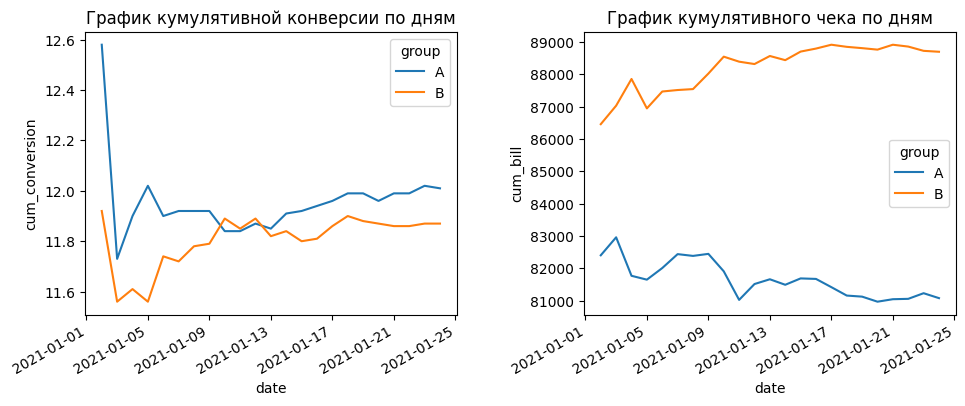

In [124]:
# Визуализируем куммулятивные метрики

# создаём фигуру размером 8x4
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=axes[0])
sns.lineplot(x='date', y='cum_bill', data=daily_data, hue='group', ax=axes[1])
axes[0].set_title('График кумулятивной конверсии по дням')
axes[1].set_title('График кумулятивного чека по дням')
plt.tight_layout() #выравнивание графиков
fig.autofmt_xdate() # автовыравнивание подписей


Можно сделать вывод, что где-то с 13ого числа метрики стабилизировались. Конверсия-A в целом держалась выше конверсии-В за исключением нескольких дней в середине, когда они сближались. Потом метрики стабилизировались, но разница между ними может оказаться незначительной. Средний чек В стабильно держится выше среднего чека группы А и со временем эта разница стала еще более явной

## 5. Статистический анализ результатов A/B-тестирования

- Сформулируем статистические гипотезы, соответствующие поставленным бизнес-вопросам, и выберем статистический тест для их проверки.

- С помощью аппарата статистических тестов определим:

    - Есть ли статистическая разница между конверсиями в группах А и B?
    - Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

- Подкрепим результаты статистических тестов, построив 95 % доверительные интервалы для:

    - конверсий в каждой из групп;
    - разницы конверсий в группах;
    - ежедневного среднего чека в каждой из групп.

Сформируем двусторонние гипотезы:

Н0: Конверсия группы A статистически равна конверсии группы В \
Н1: Конверсии в двух группах отличаются

Н0: Средний чек группы A статистически равен среднему чеку группы В \
Н1: Средние чеки в двух группах отличаются

По ходу исследование по мере необходимости можно будет проверить и одновсторонние


**Для конверсии будем использовать тест ХИ-2 для пропорций, а для среднего чека - если распределение будет нормальным, то воспользуемся Т-тестом, если отличное от нормального то - Манна — Уитни (U-тест)**

In [149]:
# начнем с конверсии, проведем тест хи-2 для пропорции - сначала посчитаем число успехов и наблюдений по покупкам туров
converted_piv= data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv)

from statsmodels.stats.proportion import proportions_chisquare

alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=converted_piv['sum'], #число «успехов»
    nobs=converted_piv['count'] #общее число наблюдений
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

,sum,count
group,,
A,17220,143332
B,17025,143432


p-value:  0.233
У нас нет оснований отвергнуть нулевую гипотезу


У нас нет оснований полагать, что конверсия как-то статистически значимо отличается у двух групп. Теперь что по чекам

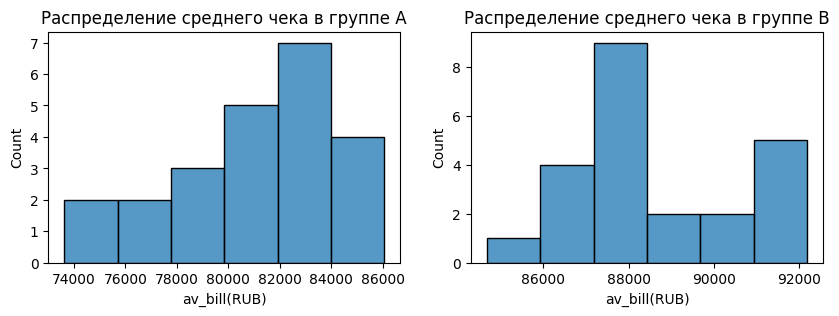

In [142]:
# посмотрим на распределения среднего чека по группам
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
# строим гистограмму для времени на сайте в каждой группе
sns.histplot(data=daily_data.loc[daily_data['group']=='A', 'av_bill(RUB)'], ax=axes[0])
sns.histplot(data=daily_data.loc[daily_data['group']=='B', 'av_bill(RUB)'], ax=axes[1])
# задаём названия графикам
axes[0].set_title('Распределение среднего чека в группе А');
axes[1].set_title('Распределение среднего чека в группе B');

Примечание: данные для графиков из начальных данных до преобразований

In [143]:
# проверим распределение среднего чека 
alpha = 0.05 # уровень значимости
# значения среднего чека
av_bill_A = shapiro(daily_data.loc[daily_data['group']=='A', 'av_bill(RUB)'])
av_bill_B = shapiro(daily_data.loc[daily_data['group']=='B', 'av_bill(RUB)'])

# сравниваем полученное p-value для группы А с уровнем значимости
if av_bill_A.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if av_bill_B.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")


Принимаем нулевую гипотезу. Распределение в группе А является нормальным
Принимаем нулевую гипотезу. Распределение в группе B является нормальным


Распрделение нормальное, следовательно используем Т-тест

In [144]:
from scipy.stats import ttest_ind

# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data.loc[daily_data['group']=='A', 'av_bill(RUB)'],
    b=daily_data.loc[daily_data['group']=='B', 'av_bill(RUB)'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Средние чеки очевидно не равны, тогда предположим, что чек в группе В выше, как было указано на графиках выше

In [148]:
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data.loc[daily_data['group']=='A', 'av_bill(RUB)'],
    b=daily_data.loc[daily_data['group']=='B', 'av_bill(RUB)'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Все верно, чек в группе B согласно точечным тестам статистически значимо превышает средний чек в группе А.

**В итоге различие в конверсиях оказалось незначительным, но средний чек в тестовой группе явно оказался лучше.** Рассмотрим теперь интервальные оценки.

In [150]:
# посчитаем конверсию в обеих группах, воспользуемся фнукцией из юнита

def proportion_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z-критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

In [151]:
# фильтруем данные группы А
a_data = data[data['group'] == 'A']
# фильтруем данные группы B
b_data = data[data['group'] == 'B']

In [152]:
from scipy.stats import norm

# строим доверительный интервал для конверсии в группе А
lower_bound_a, upper_bound_a  = proportion_conf_interval(
    x_p=a_data['purchase'].mean(), # выборочная пропорция
    n=a_data['user_id'].count() # размер выборки
)

# строим доверительный интервал для конверсии в группе B
lower_bound_b, upper_bound_b  = proportion_conf_interval(
    x_p=b_data['purchase'].mean(), # выборочная пропорция
    n=b_data['user_id'].count() # размер выборки
)

# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (11.85, 12.18)
Доверительный интервал для конверсии в группе B: (11.7, 12.04)


Довольно большое пересечение, что в целом соответствует выводам по точечной оценке. Сделаем тест на разницу конверсии для того, чтобы убедиться

In [153]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [154]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
x_p = [a_data['purchase'].mean(), b_data['purchase'].mean()]

# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)

# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Т.к. часть интервала отрицательная, а часть положительная, статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

Теперь построим доверительный интервал для среднего чека в каждой из групп. Для этого изначально разделим дневные данные на 2 группы

In [162]:
daily_data_A = daily_data[daily_data['group']=='A']['av_bill(RUB)']
daily_data_B = daily_data[daily_data['group']=='B']['av_bill(RUB)']
daily_data_A

0     82401.13
2     83224.93
4     80114.36
6     81358.97
8     83280.00
10    84320.51
12    82089.17
14    82846.15
16    77725.44
18    73621.13
20    86066.41
22    83231.79
24    79643.73
26    84065.24
28    81462.80
30    77860.70
32    77213.11
34    80576.18
36    78092.02
38    82353.64
40    81277.42
42    84546.54
44    75228.31
Name: av_bill(RUB), dtype: float64

Считаем доверительный интервал для среднего чека группы А

In [174]:
n = 23 # размер выборки
k = n - 1 # число степеней свободы
x_mean = daily_data_A.mean() # выборочное среднее
x_std = daily_data_A.std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое
print(t_crit)

def t_mean_conf_interval(x_mean, x_std, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

# cтроим доверительный интервал для среднего при неизвестном СКО
lower_bound, upper_bound = t_mean_conf_interval(x_mean, x_std, n, gamma)

# выводим результат
print('Доверительный интервал среднего чека в группе А: {}'.format((round(lower_bound), round(upper_bound))))

2.0738730679040147
Доверительный интервал среднего чека в группе А: (79626, 82339)


In [175]:
x_mean = daily_data_B.mean() # выборочное среднее
x_std = daily_data_B.std() # выборочное стандартное отклонение

# cтроим доверительный интервал для среднего при неизвестном СКО
lower_bound_B, upper_bound_B = t_mean_conf_interval(x_mean, x_std, n, gamma)

# выводим результат
print('Доверительный интервал среднего чека в группе B: {}'.format((round(lower_bound_B), round(upper_bound_B))))

Доверительный интервал среднего чека в группе B: (87726, 89516)


Доверительные интервалы средних чеков в 2ух группах не пересекаются, отсюда можно сделать, что их различие статистически значимо

## 6. Вывод


Смена посадочной страницы на вариант В имеет смысл, если целью компании является увеличение среднего чека путем смещения фокуса с туров Турции на Тайланд. Такое изменение возможно, а разница в среднем чеке ощутима и статистически значима. Если цель - повышение конверсии, то изменение посадочной страницы не приведет к данному результаты, поскольку разница в конверсии статистически не значима как по точечным, так и по интервальным оценкам.